# Proyek Klasifikasi Gambar: Animals classification dataset (https://www.kaggle.com/datasets/antobenedetti/animals)
- **Nama:** Muhammad Rizki AL-Fathir
- **Email:** alfthr378@gmail.com
- **ID Dicoding:** PetaniHandal

## Import Semua Packages/Library yang Digunakan

In [1]:
%pip install tensorflow==2.18
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from importlib.metadata import files
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


2025-04-24 15:41:38.801691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745509299.128812      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745509299.199829      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Data Preparation

### Data Loading

loading data menggunakan kaggle

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("antobenedetti/animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animals


In [4]:
path = path + '/animals'

In [5]:
path

'/kaggle/input/animals/animals'

### Data Preprocessing

#### Split Dataset

In [6]:
!ls /kaggle/input/animals/animals


inf  train  val


- inf adalah folder untuk example inference
- train adalah data train
- val adalah data val

In [7]:


train_dir = path + "/train"
val_dir = path + "/val"

def count_files_in_dir(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

train_count = count_files_in_dir(train_dir)
val_count = count_files_in_dir(val_dir)

print(f"Number of files in train directory (including subfolders): {train_count}")
print(f"Number of files in val directory (including subfolders): {val_count}")


Number of files in train directory (including subfolders): 13474
Number of files in val directory (including subfolders): 1497


In [8]:
train = 13474
val = 1497
total = train + val

train_percentage = (train_count / total) * 100
val_percentage = (val_count / total) * 100

print(f"Persentase train: {train_percentage:.2f}%")
print(f"Persentase val: {val_percentage:.2f}%")

Persentase train: 90.00%
Persentase val: 10.00%


maka train akan di split kembali dengan proporsi 80/20, sehingga persentase splitting nya sebagai berikut

- 70 train
- 20 val
- 10 test (nama folder bawaan adalah val)

splitting train akan dilakukan dalam validation split di image data generator flow from directory


### Augmentasi data

In [9]:
base_dir = path

# Prepare data generators for model training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split = 2/9, # dari 90% data train, diambil 20% untuk validasi
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

### Train dan test generator

In [10]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    subset='training',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    subset='validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
)


test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
)
print("\nData generators created successfully.")

Found 10482 images belonging to 5 classes.
Found 2992 images belonging to 5 classes.
Found 1497 images belonging to 5 classes.

Data generators created successfully.


### menampilkan sample image

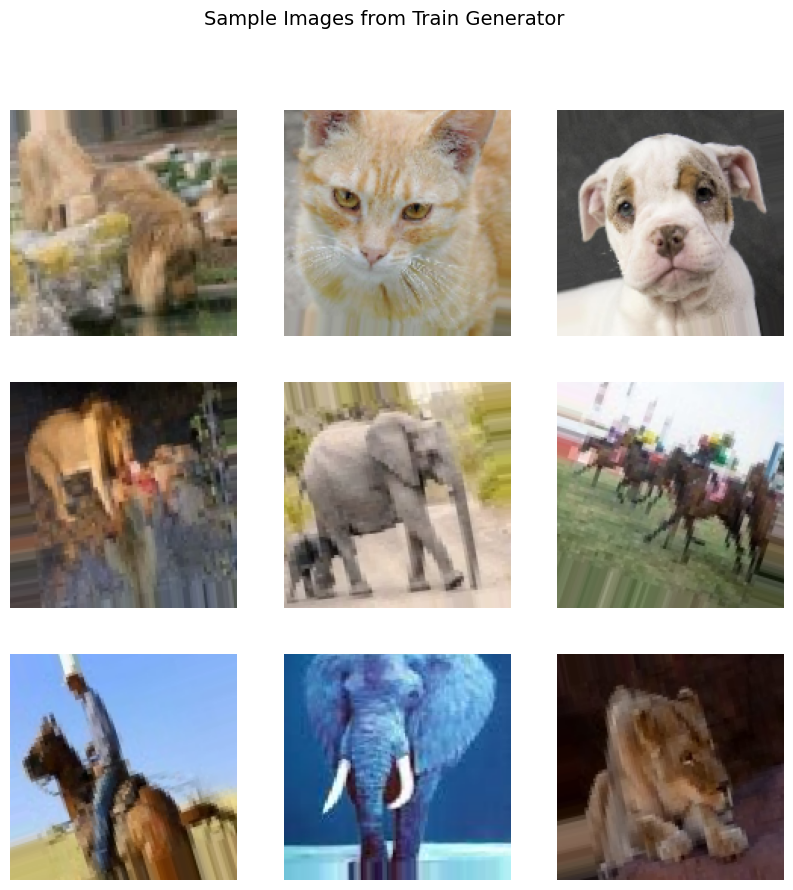

In [11]:
sample_images, sample_labels = next(train_generator)
sample_images = sample_images * 255
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)

    img = sample_images[i].astype("uint8")
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Sample Images from Train Generator", fontsize=14)
plt.show()


### Menampilkan variasi resolusi

In [12]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(train_dir)

horse: 2705
- (1024, 602)
- (1024, 611)
- (1600, 1320)
- (206, 244)
- (1200, 1200)
- (336, 448)
- (360, 140)
- (177, 284)
- (201, 251)
- (1024, 705)
- (500, 318)
- (1024, 714)
- (627, 1024)
- (276, 183)
- (772, 1024)
- (1024, 723)
- (1024, 970)
- (1024, 741)
- (280, 180)
- (1024, 997)
- (500, 421)
- (272, 185)
- (257, 196)
- (292, 172)
- (500, 439)
- (1024, 835)
- (284, 177)
- (209, 241)
- (600, 800)
- (685, 1024)
- (1024, 700)
- (321, 311)
- (244, 207)
- (1024, 718)
- (233, 216)
- (1024, 727)
- (1299, 941)
- (300, 224)
- (345, 146)
- (1024, 565)
- (1024, 574)
- (1269, 787)
- (1024, 583)
- (325, 155)
- (352, 288)
- (453, 340)
- (383, 132)
- (1024, 686)
- (2521, 1607)
- (1024, 695)
- (221, 228)
- (1024, 704)
- (224, 224)
- (1800, 1200)
- (531, 799)
- (189, 266)
- (276, 182)
- (824, 1024)
- (1088, 725)
- (1024, 960)
- (225, 225)
- (160, 315)
- (320, 215)
- (1024, 578)
- (282, 179)
- (274, 184)
- (294, 171)
- (385, 289)
- (255, 198)
- (286, 176)
- (334, 500)
- (1024, 681)
- (294, 198)
- (

## Modelling

### menggunakan transfer learning dengan finetune mobilenetv2

In [13]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

In [14]:

int_lr = 1e-4
num_epochs = 20

pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

for layer in pre_trained_model.layers[-30:]:
    layer.trainable = True

last_output = pre_trained_model.output
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(last_output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)
optimizer = tf.optimizers.Adam(learning_rate=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


H = model.fit(train_generator,
              epochs=num_epochs,
              callbacks=[early_stop],
              validation_data = validation_generator)

/tmp/ipykernel_31/139843451.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
I0000 00:00:1745509451.390072      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745509451.390797      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745509469.938169     126 service.cc:148] XLA service 0x7f02ec003ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745509469.939057     126 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745509469.939085     126 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745509471.401531     126 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/328 ━━━━━━━━━━━━━━━━━━━━ 2:17:57 25s/step - accuracy: 0.1562 - loss: 2.4008

I0000 00:00:1745509479.626830     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


328/328 ━━━━━━━━━━━━━━━━━━━━ 138s 346ms/step - accuracy: 0.6667 - loss: 0.9188 - val_accuracy: 0.9017 - val_loss: 0.2723
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 98s 296ms/step - accuracy: 0.9023 - loss: 0.3176 - val_accuracy: 0.9081 - val_loss: 0.2688
Epoch 3/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 97s 292ms/step - accuracy: 0.9227 - loss: 0.2415 - val_accuracy: 0.9322 - val_loss: 0.2156
Epoch 4/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 97s 290ms/step - accuracy: 0.9419 - loss: 0.1934 - val_accuracy: 0.9285 - val_loss: 0.2188
Epoch 5/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 95s 284ms/step - accuracy: 0.9471 - loss: 0.1637 - val_accuracy: 0.9425 - val_loss: 0.1735
Epoch 6/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 94s 283ms/step - accuracy: 0.9544 - loss: 0.1489 - val_accuracy: 0.9485 - val_loss: 0.1567
Epoch 7/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 96s 288ms/step - accuracy: 0.9556 - loss: 0.1358 - val_accuracy: 0.9505 - val_loss: 0.1477
Epoch 8/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 112s 335ms/step - accuracy: 0.9635 - loss: 0.1133 - v

## Evaluasi dan Visualisasi

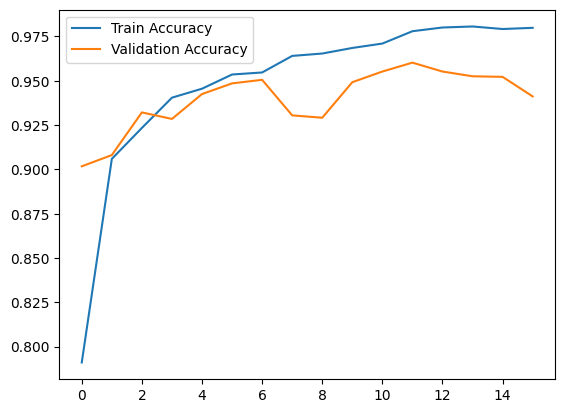

In [15]:
plt.plot(H.history['accuracy'], label='Train Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


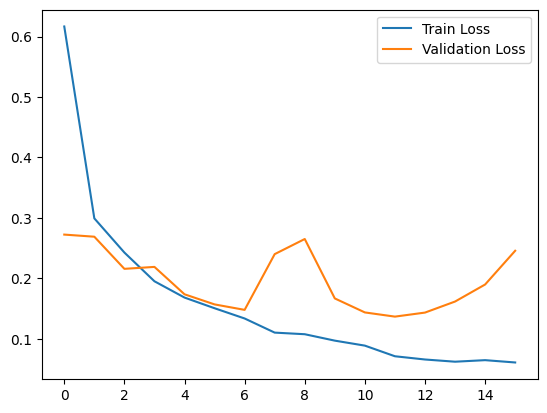

In [16]:
plt.plot(H.history['loss'], label='Train Loss')
plt.plot(H.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [17]:
loss, accuracy = model.evaluate(test_generator)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.9654 - loss: 0.1182
Test Loss: 0.12729555368423462
Test Accuracy: 0.962591826915741


In [18]:
loss, accuracy = model.evaluate(validation_generator)

print(f"val Loss: {loss}")
print(f"val Accuracy: {accuracy}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - accuracy: 0.9533 - loss: 0.1497
val Loss: 0.15458157658576965
val Accuracy: 0.9528743028640747


In [19]:
loss, accuracy = model.evaluate(train_generator)

print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy}")


328/328 ━━━━━━━━━━━━━━━━━━━━ 75s 230ms/step - accuracy: 0.9878 - loss: 0.0344
Train Loss: 0.03641333431005478
Train Accuracy: 0.9860713481903076


## Konversi Model

SavedModel

In [20]:
model.save('animals_classif.keras')

In [21]:
model = tf.keras.models.load_model('/kaggle/working/animals_classif.keras')

In [22]:
model.export('/kaggle/working/')

Saved artifact at '/kaggle/working/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139654109355792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654109353872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654109354640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654109352912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654109356176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654109354832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654109351952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654109351568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654109350608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654109352336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139654192163024

Tf-lite

In [23]:

model = tf.keras.models.load_model('/kaggle/working/animals_classif.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('animals_classif.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp732lj4r8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139650697378896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139650697377744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139650697377360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139650697377936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139650697378512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139650697377552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139650697375056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139650697374864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139650697375248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139650697375824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139650697374480

W0000 00:00:1745511218.474555      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745511218.474591      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1745511218.596542      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Tf-js

In [25]:
!pip install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

tfjs tidak kompatibel dengan .keras, sehingga harus disimpan kedalam .h5 terlebih dahulu

In [27]:
model.save("animal_classif.h5", save_format="h5")


In [32]:
!tensorflowjs_converter \
  --input_format=keras \
  /kaggle/working/animal_classif.h5 \
  /kaggle/working/tfjs_model/


2025-04-24 16:26:14.565598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745511974.586672     539 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745511974.592879     539 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

Inference akan dilakukan di notebook yang lain